# Singular WF test

In [18]:
from Hubbard.core import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la
import torch

N = 16
R0 = np.array([3, 3, 7.2])
dvr = MLWF(
    N=N,
    R0=R0,
    lattice=np.array([4], dtype=int),
    trap=(50, 1000),
    lc=(200, 1600),
    band=1,
    dim=1,
    avg=1,
    sparse=True,
    symmetry=True,
    verbosity=0)

E, W, parity = eigen_basis(dvr)
E = E[0]
W = W[0]
p = parity[0]
print(f'E = {E}')
print(f'parity = {p}')

R = Xmat(dvr, W, p)
R = [torch.from_numpy(Ri) for Ri in R]
dvr.verbosity = 3
solution = riemann_optimize(dvr, None, R)
R = R[0].numpy()
shift = np.zeros((dvr.Nsite, dim))
for i in range(dvr.Nsite):
    shift[i, :2] = dvr.trap_centers[i] * dvr.lc
    # Small offset to avoid zero WF on z=0 in z-odd band
    # Only when calculation is in 3D that pz = -1 is possible
    # Roughly shift_z is at the peak of the 1st-excited z function
    shift[i, 2] = dvr.hl[2]/dvr.w if all(p[:, 2] == -1) else 0
x = [[[shift[i, d]] for d in range(dim)] for i in range(dvr.Nsite)]
center_val = np.zeros((dvr.Nsite, dvr.Nsite))
for i in range(dvr.Nsite):
    center_val[i, :] = abs(wannier_func(dvr, W, solution, p, x[i]))
# print(center_val)
# Find at which trap max of Wannier func is
order = np.argmax(center_val, axis=1)
U = solution[:, order]
A = U.conj().T @ (E[:, None] * U) * dvr.V0 / dvr.kHz_2p
print('detU =', la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p,  p)
# for i in range(dvr.bands):
#     mu = np.diag(A[i])  # Diagonals are mu_i
#     t = -(A[i] - np.diag(mu))  # Off-diagonals are t_ij
#     print(f'V_{i+1}_i = ', np.real(mu))
#     print(f't_{i+1}_ij =', abs(t))
mu = np.diag(A)  # Diagonals are mu_i
t = -(A - np.diag(mu))  # Off-diagonals are t_ij
print('V_i = ', np.real(mu))
print('t_ij =', abs(t))
print('U_i =', abs(V))


Solve (1, 1, 1) sector.
Solve (-1, 1, 1) sector.
E = [-1.60286802 -1.19906375 -0.83989712 -0.52978757]
parity = [[ 1  1  1]
 [-1  1  1]
 [ 1  1  1]
 [-1  1  1]]
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +5.2648558764784226e-01    3.62675215e-01    
   2         +2.5375836940002811e-01    3.43259631e-01    
   3         +2.0549427839891127e-01    4.73449033e-01    
   4         +1.1379642234977791e-01    4.47622810e-01    
   5         +6.3305853303869730e-02    2.17647272e-01    
   6         +5.0313228145544342e-02    1.42270196e-01    
   7         +3.9103655738530786e-02    1.03703685e-01    
   8         +2.7449744977559750e-02    8.86679250e-02    
   9         +1.6909124494142995e-02    8.92880643e-02    
  10         +4.0638292854538616e-03    4.26501233e-02    
  11         +2.1774413128040938e-03    3.98456895e-02    
  12         +4.1431019848850166e-04    2.42432253e-02    

In [34]:
solution.T @ R @ solution

array([[-5.18953913e-01,  9.22926429e-09, -5.85378010e-09,
         1.25244460e-07],
       [ 9.22926427e-09,  1.60158837e-01, -7.87973971e-07,
         7.62513546e-09],
       [-5.85378008e-09, -7.87973971e-07, -1.60158837e-01,
        -4.06292023e-08],
       [ 1.25244460e-07,  7.62513545e-09, -4.06292023e-08,
         5.18953913e-01]])

In [36]:
center_val

array([[0.86056259, 0.38768663, 1.27707299, 0.22896173],
       [0.22927398, 0.40555615, 1.63941306, 0.19257681],
       [0.192577  , 1.63941106, 0.40556422, 0.22927385],
       [0.22896186, 1.27707488, 0.3876804 , 0.86056255]])

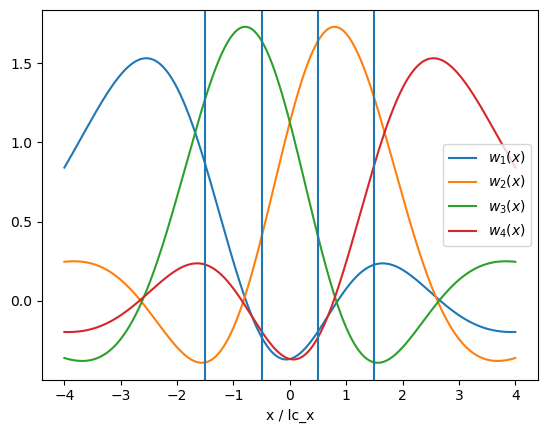

In [38]:
import matplotlib.pyplot as plt

x = np.linspace(-4 * dvr.lc[0], 4 * dvr.lc[0], 500)
y = np.array([0])
z = np.array([0])
plt.plot(x / dvr.lc[0],
         fix_phase(wannier_func(dvr, W, solution, p,
                                [x, y, z])[:, 0, 0, :]),
         label=tuple(f'$w_{i + 1}(x)$' for i in range(dvr.Nsite)))
plt.xlabel('x / lc_x')
plt.legend()
plt.axvline(-1.5)
plt.axvline(-0.5)
plt.axvline(1.5)
plt.axvline(0.5)

### 2D square expectation value test

In [19]:
from Hubbard.core import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la
import torch

N = 16
R0 = np.array([3, 3, 7.2])
dvr = MLWF(
    N=N,
    R0=R0,
    lattice=np.array([3, 3], dtype=int),
    trap=(50, 1000),
    lc=(500, 600),
    band=1,
    dim=2,
    sparse=True,
    symmetry=True,
    verbosity=0)

E, W, parity = eigen_basis(dvr)
E = E[0]
W = W[0]
p = parity[0]
print(f'E = {E}')
print(f'parity = {p}')

R = Xmat(dvr, W, p)
R = [torch.from_numpy(Ri) for Ri in R]
dvr.verbosity = 3
solution = riemann_optimize(dvr, None, R)
shift = np.zeros((dvr.Nsite, dim))
for i in range(dvr.Nsite):
    shift[i, :2] = dvr.trap_centers[i] * dvr.lc
    # Small offset to avoid zero WF on z=0 in z-odd band
    # Only when calculation is in 3D that pz = -1 is possible
    # Roughly shift_z is at the peak of the 1st-excited z function
    shift[i, 2] = dvr.hl[2]/dvr.w if all(p[:, 2] == -1) else 0
x = [[[shift[i, d]] for d in range(dim)] for i in range(dvr.Nsite)]
center_val = np.zeros((dvr.Nsite, dvr.Nsite))
for i in range(dvr.Nsite):
    center_val[i, :] = abs(wannier_func(dvr, W, solution, p, x[i]))
# print(center_val)
# Find at which trap max of Wannier func is
order = np.argmax(center_val, axis=1)
U = solution[:, order]
A = U.conj().T @ (E[:, None] * U) * dvr.V0 / dvr.kHz_2p
print('detU =', la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p,  p)
# for i in range(dvr.bands):
#     mu = np.diag(A[i])  # Diagonals are mu_i
#     t = -(A[i] - np.diag(mu))  # Off-diagonals are t_ij
#     print(f'V_{i+1}_i = ', np.real(mu))
#     print(f't_{i+1}_ij =', abs(t))
mu = np.diag(A)  # Diagonals are mu_i
t = -(A - np.diag(mu))  # Off-diagonals are t_ij
print('V_i = ', np.real(mu))
print('t_ij =', abs(t))
print('U_i =', abs(V))


Solve (1, 1, 1) sector.
Solve (1, -1, 1) sector.
Solve (-1, 1, 1) sector.
Solve (-1, -1, 1) sector.
E = [-3.90735282 -3.49386643 -3.41085514 -3.07857026 -3.01058866 -2.92901348
 -2.66746656 -2.60992278 -2.54180532]
parity = [[ 1  1  1]
 [ 1 -1  1]
 [-1  1  1]
 [ 1  1  1]
 [-1 -1  1]
 [ 1  1  1]
 [ 1 -1  1]
 [-1  1  1]
 [ 1 -1  1]]
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +9.9556214226390760e-01    4.72684346e-01    
   2         +6.4016302407145120e-01    4.47002519e-01    
   3         +4.7150160810756503e-01    4.00750195e-01    
   4         +3.5749830487167689e-01    2.40965374e-01    
   5         +3.0426950251821017e-01    1.65749845e-01    
   6         +2.6167870518094183e-01    1.42197836e-01    
   7         +2.2887471249026431e-01    1.59556079e-01    
   8         +2.0515989398795942e-01    9.76714918e-02    
   9         +1.9697663530498249e-01    7.75609011e-02    
  10

In [20]:
a = []
a.append(np.diag(solution.T @ R[0].numpy() @ solution))
a.append(np.diag(solution.T @ R[1].numpy() @ solution))
a = np.array(a).T

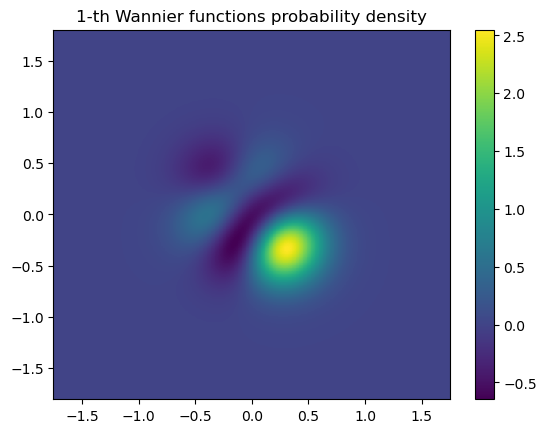

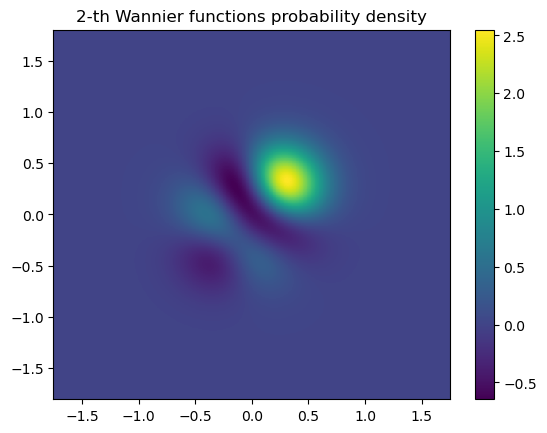

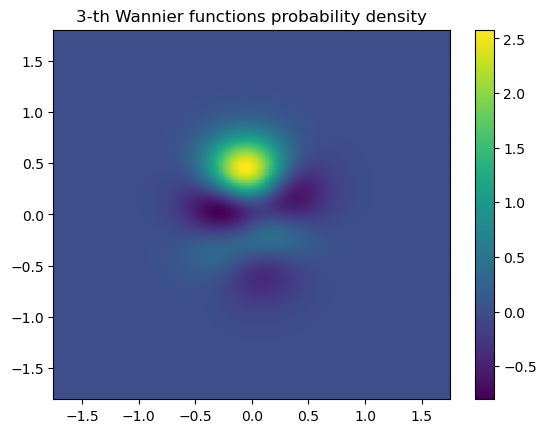

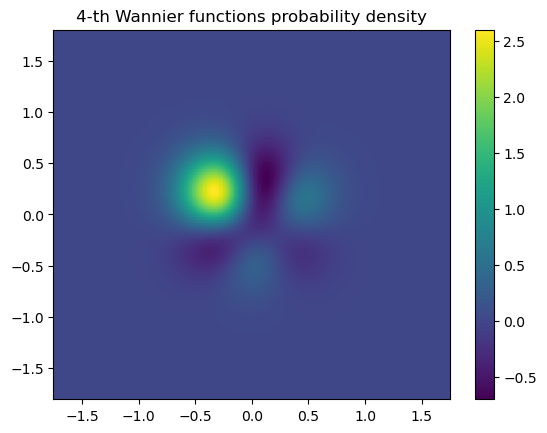

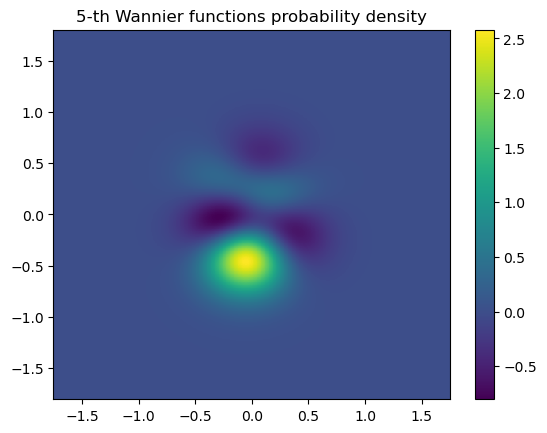

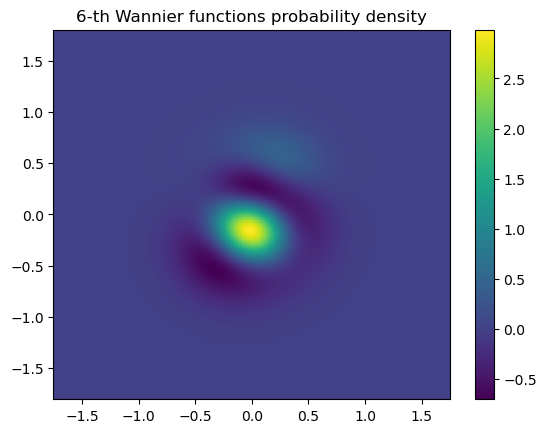

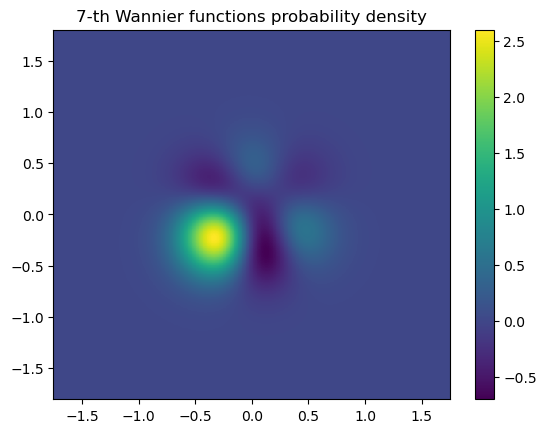

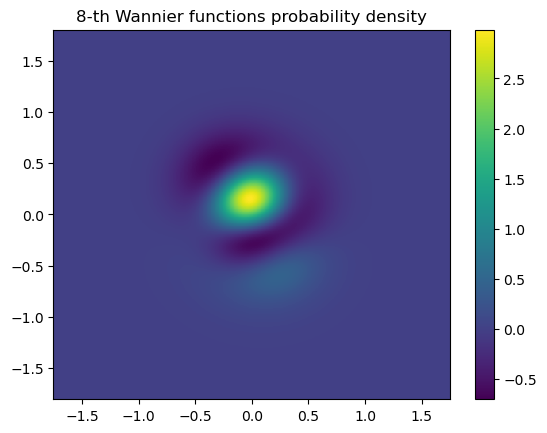

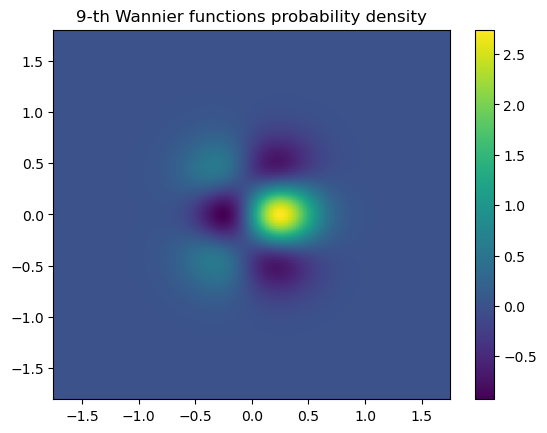

In [25]:
import matplotlib.colors as colors
from tools.fix_phase import fix_phase
import matplotlib.pyplot as plt
x = np.linspace(-dvr.R0[0] / 2, dvr.R0[0] / 2, 500)
y = np.linspace(-dvr.R0[1] / 2, dvr.R0[1] / 2, 500)
z = np.array([0])
wx = wannier_func(dvr, W, solution, p, (x, y, z))
X = np.meshgrid(x, y, indexing='ij')

for i in range(dvr.Nsite):
    Wx = fix_phase(wx[..., 0, i], mode='svmd')
    plt.figure()
    plt.pcolormesh(*X, Wx)
    plt.colorbar()
    plt.title(f'{i+1}-th Wannier functions probability density')


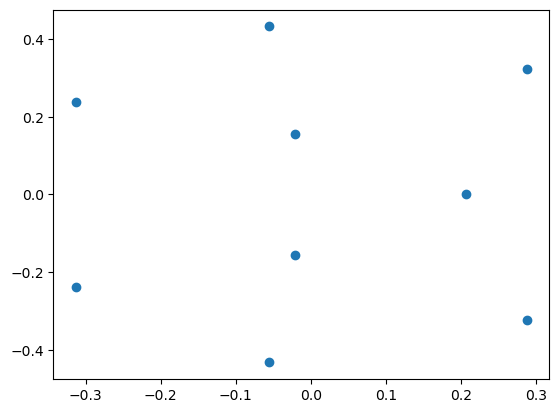

In [24]:
import matplotlib.pyplot as plt

plt.plot(a[:, 0], a[:, 1], 'o')